<a href="https://colab.research.google.com/github/gideon1971/CMS-convexity/blob/main/notebooks/SwaptionWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examine the sensitivity of CMS convexity calculations based on different initial parameter assumptions #

<h4> acknowledgement to FinancePy for the displaced SABR volatility code https://github.com/domokane/FinancePy </h4>


### Introduction ###

Constant Maturity Swaps use the same framework as vanilla swaps, however, the tenor of the floating index is not in line with the tenor of the floating payments. 

For example, receiver EURIBOR swap will pay an amount at the end of a 6 month coupon per4iod (in arrears). The amount will be based on the EURIBOR 6 month fixing SET IN ADVANCE of a semi-annual floating payment coupon period. \Similarly for OIS swqpw. the floating rate will use the daily compounded rat3s over trhe coupon period.

The floating index used for CMS can be a swap rate of any tenor. 
Pay 20y swap rate

10-year EUR CMS Swap Rate and the 20-year EUR
CMS Swap Rate (displayed on the Reuters page "ICESWAP2").



This would be the rate used to determinbe if a swaption exerfc ises withe a tenor   but the index that fixes is not a term rate or 



### Calculating the weights for for a portfolio of Cash Settled Swaptions to replicate a CMS rate

### Setup
-  Choose the number of swaptions for each Call & Put portfilio. e.g. use 30
-  determine which strikes to use
-  create functions to build the list of strikes & forwards
-  crate a PVBP function



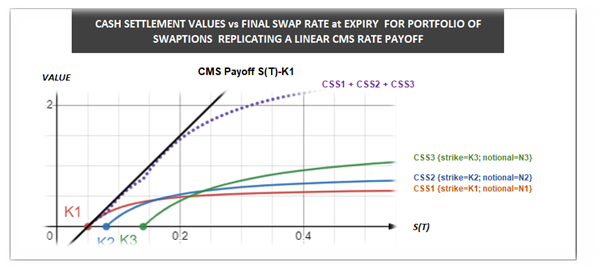

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt

from financepy.utils import *
from financepy.models.sabr_shifted import *

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:42 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [ ]:
def N(x):
    Ndist = si.norm.cdf(x,0.0,1.0)
    return Ndist

In [ ]:

def B76(ff,kk,tt,vol,ss,cp):# ff= forward, kk = strike, ss=displacement
    
    # create displaced forwards & srtikes
    ff=ff+ss
    kk=kk+ss

    d1=(np.log(ff/kk) + 0.5* tt * vol**2)/(vol * (tt**0.5))
    d2=(np.log(ff/kk) - 0.5* tt * vol**2)/(vol * (tt**0.5))

    c=ff*N(d1)-kk*N(d2)
    p=kk*N(-d2)-ff*N(-d1)

    if cp==1:
        retval=c
    else:
        retval=p

    return retval

In [ ]:
def getStrikes(anchorStrike, displacement=0, CallPut = "CALL", nCashSettledSwaptions=30):

    if CallPut == "CALL":
        finalStrike = 10 * (anchorStrike + displacement)
    else:
        finalStrike = -displacement + 0.000001

    increment = (finalStrike-anchorStrike)/(nCashSettledSwaptions-1)
    cashSettledSwaptionStrikes = [anchorStrike + i * increment for i in range(nCashSettledSwaptions)]
            
    return cashSettledSwaptionStrikes

In [ ]:
def getForwards(anchorStrike, displacement=0, CallPut = "CALL", nCashSettledSwaptions=30):
    
    K=getStrikes(anchorStrike, displacement, CallPut, nCashSettledSwaptions)
    
    increment=K[1]-K[0]

    cashSettledSwaptionForwards =[K[i] + increment/2  for i in range(nCashSettledSwaptions)]
            
    return cashSettledSwaptionForwards

In [ ]:
def PVBP(swapParRate,swapTenorInMonths,swapFixedLegPaymentTenorInMonths):
    #calculate the cash settled swaption annuity at exercise

    factor=swapFixedLegPaymentTenorInMonths/12
    nPaymemnts=int(swapTenorInMonths/swapFixedLegPaymentTenorInMonths)
    df = 1/(1 + swapParRate*factor)
            
    s=0.0
    p=1.0
    for i in range(nPaymemnts):
        p*=df
        s+=p
                
    return s * factor

In [ ]:
def largest(a,b):
    if a>b:
        r=a
    else:
        r=b
    return r

In [ ]:
#The weights can be calculated recursively by calculating theterninal payoff

def calculateWeights(callputN,anchorStrike,displacement,swapTenorinMonths,swapFixedLegMonths,nCashSettledSwaptions=30):
    
    
    CSSweights=[] # create the empty list to hold the weights
    swapTenor=swapTenorinMonths

    if callputN==1:
        CallPut="CALL"
    else:
        CallPut="PUT"
    
    
    Strikes=getStrikes(anchorStrike, displacement, CallPut, nCashSettledSwaptions)
    Forwards=getForwards(anchorStrike, displacement, CallPut, nCashSettledSwaptions)

    # the target rate is the CMS rate at each forward rate
    Targets=[Forwards[i]-anchorStrike for i in range(nCashSettledSwaptions)] 


    for i in range(nCashSettledSwaptions):
        #find weight

        currentFwd=Forwards[i]
        currentPVBP=PVBP(currentFwd,swapTenor,swapFixedLegMonths)

        nFixedStrikes=len(CSSweights) # loopp through the strikes that have already had their weight set
        #print(nFixedStrikes)
        prevPV=0

        if nFixedStrikes>0: # use this once we have calculated the first swaption weight
             for w in range(nFixedStrikes):
                prevPV=prevPV + largest(callputN*(currentFwd-Strikes[w]),0) * currentPVBP * CSSweights[w]
            
        else:
            prevPV=0
           
        requiredPV=Targets[i]-prevPV
        currentWeight= requiredPV / (largest(callputN*(currentFwd-Strikes[i]),0)*currentPVBP)
        CSSweights.append(currentWeight)

    return CSSweights,Strikes

In [ ]:
def getConvexityAdjustedSwapRate(F,D,T,swapLengthinMonths,nCashSettledSwaptions,fixedlegfreqmonths, SABRparams):
    
    #Calls
    wCalls, kCalls = calculateWeights(1,F,D,swapLengthinMonths,fixedlegfreqmonths,nCashSettledSwaptions)
    #Puts
    wPuts, kPuts = calculateWeights(-1,F,D,swapLengthinMonths,fixedlegfreqmonths,nCashSettledSwaptions)


    #define shifted SABR parameters
    alpha = SABRparams[0]; beta = SABRparams[1]; rho = SABRparams[2]; nu = SABRparams[3]; shift = D
    model = SABRShifted(alpha, beta, rho, nu, D)

    volsSABRCalls = model.black_vol(F, np.array(kCalls),T)
    volsSABRPuts = model.black_vol(F, np.array(kPuts),T)

    #dcefine the annuity of the swap
    ann=PVBP(F,swapLengthinMonths,6)
    
    PVportfolioPuts=0
    PVportfolioCalls=0

    for s in range(nCashSettledSwaptions):
        kk=kCalls[s]
        w=wCalls[s]
        v=volsSABRCalls[s]

        PVportfolioCalls+=w*ann*B76(F,kk,T,v,D,1)

    for s in range (nCashSettledSwaptions):
        kk=kPuts[s]
        w=wPuts[s]
        v=volsSABRPuts[s]

        PVportfolioPuts+=w*ann*B76(F,kk,T,v,D,-1)
        

        return PVportfolioCalls+PVportfolioPuts

In [ ]:
F=0.03
D=0.0
T=2.0
swapLengthinMonths=240
nCashSettledSwaptions=30
pp=[0.102,1.0,0.5, 0.1]
zzz=getConvexityAdjustedSwapRate(F,D,T,240,30, 6 , pp)

In [ ]:
print(zzz)

0.00010641589774233002
